# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        # Инициализация
        n_samples, n_features = X.shape
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(n_features)
        self.loss_history = []

        # Функция сигмоида
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        # Запись начального значения потерь
        self.loss_history.append(self.calc_loss(X, y))
        prev_w = self.w.copy()

        for iteration in range(1, self.max_iter + 1):
            # Выбор типа градиентного спуска
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n_samples)
                Xi = X[idx:idx + 1]
                yi = y[idx:idx + 1]
                grad = self.calc_gradient(Xi, yi)
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")

            # Обновление весов
            self.w -= self.eta * grad

            # Запись значения потерь
            self.loss_history.append(self.calc_loss(X, y))

            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                break
            prev_w = self.w.copy()
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        # Вычисление вероятностей через сигмоиду
        z = X.dot(self.w)
        prob_pos = 1 / (1 + np.exp(-z))
        prob_neg = 1 - prob_pos
        return np.column_stack((prob_neg, prob_pos))


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # Предсказываем вероятности
        z = X.dot(self.w)
        p = 1 / (1 + np.exp(-z))
        # Градиент отрицательного логарифмического правдоподобия
        gradient = X.T.dot(p - y) / X.shape[0]
        return gradient


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        z = X.dot(self.w)
        p = 1 / (1 + np.exp(-z))
        # Избегаем log(0)
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

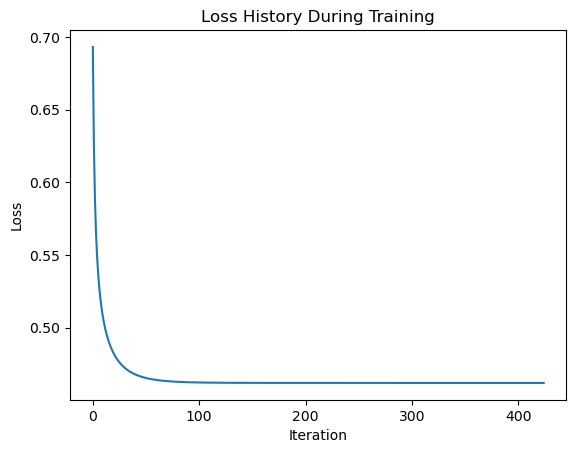

In [5]:
# Обучение модели
model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=1000, tolerance=1e-6)
model.fit(X_train, y_train)

# Построение графика лосса
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History During Training')
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

In [6]:
y_scores = model.predict_proba(X_test)[:, 1]

In [7]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, _ = roc_curve(y_test, y_scores)

In [8]:
# PR-AUC (average precision)
pr_auc = average_precision_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


ROC-AUC: 0.8586
PR-AUC: 0.8202


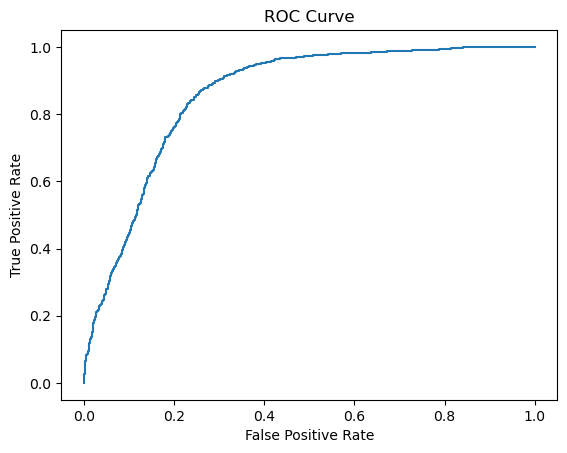

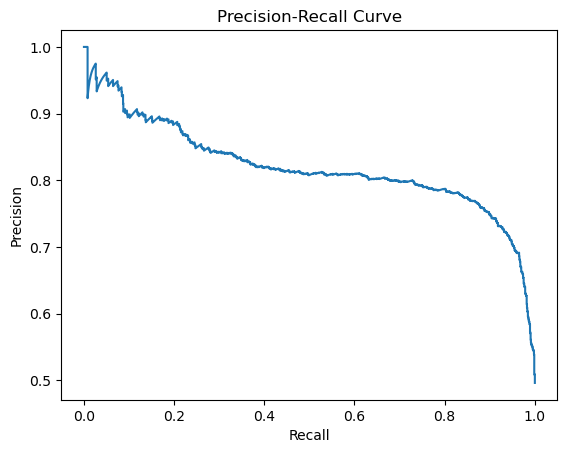

In [9]:
# Рисуем ROC-кривую
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Рисуем PR-кривую
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [10]:
# Стратифицированный K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

roc_scores = []
pr_scores = []

for train_idx, test_idx in skf.split(X, y):
    model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=1000, tolerance=1e-6)
    model.fit(X[train_idx], y[train_idx])

    # Предсказанные «шкалы» (вероятности класса 1)
    y_scores = model.predict_proba(X[test_idx])[:, 1]

    # Метрики ждут первым аргументом y_true (дискретный), вторым — y_score (необязательно бинарный)
    roc = roc_auc_score(y[test_idx], y_scores)
    pr  = average_precision_score(y[test_idx], y_scores)

    roc_scores.append(roc)
    pr_scores.append(pr)

print("ROC-AUC по фолдам: ", np.round(roc_scores, 4))
print(f"Средний ROC-AUC: {np.mean(roc_scores):.4f} ± {np.std(roc_scores):.4f}")
print("PR-AUC по фолдам:  ", np.round(pr_scores, 4))
print(f"Средний PR-AUC:  {np.mean(pr_scores):.4f} ± {np.std(pr_scores):.4f}")

ROC-AUC по фолдам:  [0.8609 0.8541 0.8665 0.858  0.8671]
Средний ROC-AUC: 0.8613 ± 0.0050
PR-AUC по фолдам:   [0.8307 0.8216 0.8389 0.8324 0.8384]
Средний PR-AUC:  0.8324 ± 0.0063


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [11]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [12]:
# `load_boston` has been removed from scikit-learn since version 1.2.

# from sklearn.datasets import load_boston
# boston = load_boston()

In [13]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
# data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [14]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_23196/16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [15]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [16]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [17]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    if R.size == 0:
        return 0.0
    y = R[:, -1]
    return np.mean((y - y.mean())**2)


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    mask_left  = R_m[:, feature_idx] <= t
    R_left     = R_m[mask_left]
    R_right    = R_m[~mask_left]
    return R_left, R_right


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    n = len(R_m)
    if n == 0:
        return 0.0
    R_left, R_right = split_node(R_m, feature_idx, t)
    return (len(R_left) / n) * H(R_left) + (len(R_right) / n) * H(R_right)


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

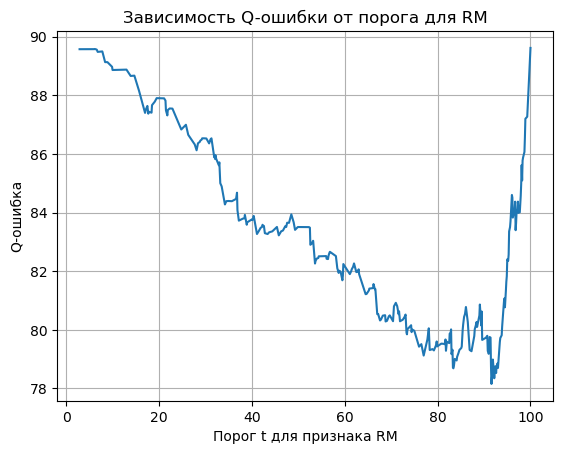

In [18]:
# Выбираем признак
feature = 'AGE'

# Все уникальные значения AGE в обучающей выборке, отсортированные
thresholds = np.sort(X_train[feature].unique())

errors = []
n = len(X_train)

for t in thresholds:
    # делим на левое/правое поддерево
    R_left  = X_train[ X_train[feature] <= t ]
    R_right = X_train[ X_train[feature]  > t ]
    # вычисляем "impurity" как дисперсию target (population variance)
    H_left  = R_left['target'].var(ddof=0) if len(R_left)  else 0.0
    H_right = R_right['target'].var(ddof=0) if len(R_right) else 0.0
    # Q-ошибка
    q = (len(R_left)/n)*H_left + (len(R_right)/n)*H_right
    errors.append(q)

# Рисуем график
plt.figure()
plt.plot(thresholds, errors)
plt.xlabel('Порог t для признака RM')
plt.ylabel('Q-ошибка')
plt.title('Зависимость Q-ошибки от порога для RM')
plt.grid(True)
plt.show()


**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [19]:
def get_optimal_split(R_m: pd.DataFrame, feature: str) -> Tuple[float, List[float]]:
    """
    Для каждого уникального значения признака feature в R_m 
    считаем Q-ошибку и находим порог t*, на котором она минимальна.
    
    Возвращает:
      t*        — оптимальный порог (float)
      errors    — List[Q_error] для каждого порога в same order as thresholds
    """
    # отсортированный список всех возможных порогов
    thresholds = np.sort(R_m[feature].unique())
    n = len(R_m)
    errors: List[float] = []
    
    # вспомогательные H и split (можно брать ваши реализации)
    def H(R: pd.DataFrame) -> float:
        return R['target'].var(ddof=0) if len(R) else 0.0

    def split_node(R: pd.DataFrame, feature: str, t: float):
        return R[R[feature] <= t], R[R[feature] > t]

    # перебираем все пороги
    for t in thresholds:
        Rl, Rr = split_node(R_m, feature, t)
        q = (len(Rl)/n) * H(Rl) + (len(Rr)/n) * H(Rr)
        errors.append(q)
    
    # находим индекс минимальной ошибки
    best_idx = int(np.argmin(errors))
    best_t   = float(thresholds[best_idx])
    
    return best_t, errors


**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Лучший признак для первого разбиения: RM
Оптимальный порог t*: 6.8330
Минимальное значение Q-ошибки: 49.3809


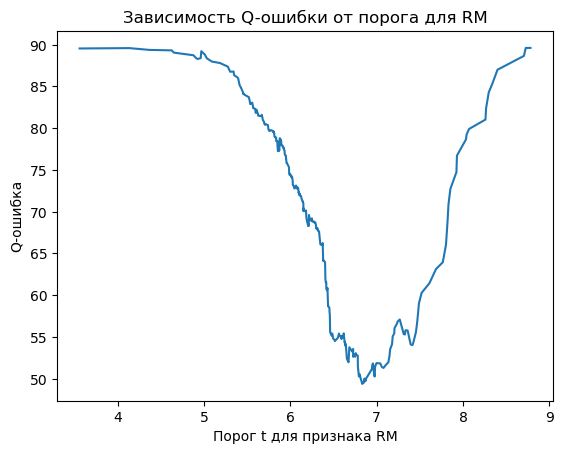

In [20]:
best_feature = None
best_t = None
best_q = np.inf
errors_dict = {}

for feature in feature_names:
    t_opt, errs = get_optimal_split(X_train, feature)
    errors_dict[feature] = (np.sort(X_train[feature].unique()), errs)
    q_val = min(errs)
    if q_val < best_q:
        best_q = q_val
        best_feature = feature
        best_t = t_opt

print(f"Лучший признак для первого разбиения: {best_feature}")
print(f"Оптимальный порог t*: {best_t:.4f}")
print(f"Минимальное значение Q-ошибки: {best_q:.4f}")

thresholds, errors = errors_dict[best_feature]
plt.figure()
plt.plot(thresholds, errors)
plt.xlabel(f'Порог t для признака {best_feature}')
plt.ylabel('Q-ошибка')
plt.title(f'Зависимость Q-ошибки от порога для {best_feature}')
plt.show()

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

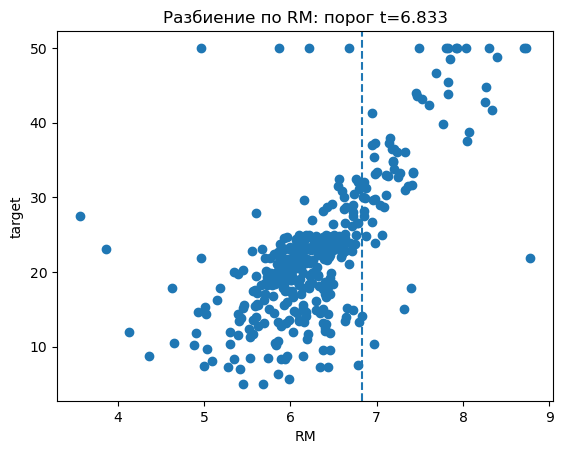

In [21]:
feature = best_feature
t_opt = best_t

plt.figure()
plt.scatter(X_train[feature], X_train['target'])
plt.axvline(x=t_opt, ymin=0, ymax=1, linestyle='--')
plt.xlabel(feature)
plt.ylabel('target')
plt.title(f'Разбиение по {feature}: порог t={t_opt:.3f}')
plt.show()